In [42]:
#Pattern Recognition and Machine Learning (PARMA) Group
#School of Computing, Costa Rica Institute of Technology
#
#title           :unet_CellSegmentation.py
#description     :Cell segmentation using pretrained unet architecture. 
#authors         :Willard Zamora wizaca23@gmail.com, 
#                 Manuel Zumbado manzumbado@ic-itcr.ac.cr

import os
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger

from skimage.io import imread, imshow
from skimage import transform


In [2]:
HOMEDIR = os.getcwd()
BBBCMASK_DIR = '/BBBC_data/mask_creation_images'
BATCH_SIZE = 64
MAX_EPOCHS = 50

In [13]:
#Compute dice coeficient used in loss function
def dice_coef(y_true, y_pred):
    #Dice coeficient parameter
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

#Loss function
def dice_coef_loss(y_true, y_pred):
    return(-dice_coef(y_true, y_pred))

#Process and image
def process_img(img_file, shape = (256,256)):
    img = imread(img_file)
    img = transform.resize(img, shape)
    img = img/255

    return(img)
    
    
#Define unet architecture
def get_unet(img_size = (256,256,1)):
    inputs = Input(img_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef, 'accuracy'])
    #model.summary()
    return(model)

SyntaxError: invalid syntax (<ipython-input-13-f21c421f6bf9>, line 17)

In [4]:
unet = get_unet()
unet.load_weights('./pretrainedUnet/pre_0_3_5.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
test_image_file = HOMEDIR + BBBCMASK_DIR + '/test/image/class0/SIMCEPImages_A01_C1_F1_s01_w2.TIF'
test_img = process_img(test_image_file)

In [5]:
data_gen_args = dict(rotation_range = 0,
                    width_shift_range=0,
                    height_shift_range=0.0,
                    zoom_range=0,
                    horizontal_flip=False,
                    fill_mode='nearest')

def trainGenerator(image_folder,mask_folder,aug_dict,batch_size = 32, image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                   target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        image_folder,
        batch_size = BATCH_SIZE,
        color_mode = image_color_mode,
        target_size = target_size,
        save_prefix  = image_save_prefix,
        save_to_dir = None,
        class_mode=None,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        mask_folder,
        batch_size = BATCH_SIZE,
        color_mode = mask_color_mode,
        target_size = target_size,
        save_prefix  = mask_save_prefix,
        save_to_dir= None,
        class_mode=None,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    return(train_generator)

In [6]:
train_image_dir = HOMEDIR + BBBCMASK_DIR + '/train/image/'
train_mask_dir = HOMEDIR + BBBCMASK_DIR + '/train/label/'
valid_image_dir = HOMEDIR + BBBCMASK_DIR + '/valid/image/'
valid_mask_dir = HOMEDIR + BBBCMASK_DIR + '/valid/label/'
TrainGen = trainGenerator(train_image_dir, train_mask_dir, data_gen_args)
ValidGen = trainGenerator(valid_image_dir, valid_mask_dir, data_gen_args)

Found 780 images belonging to 1 classes.
Found 780 images belonging to 1 classes.
Found 50 images belonging to 1 classes.
Found 50 images belonging to 1 classes.


In [7]:
model_checkpoint = ModelCheckpoint('unetCellCnt_weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                   monitor='val_loss',verbose=1, save_best_only=True)
model_earlyStop = EarlyStopping(monitor='val_loss', min_delta = 0.002, patience = 3)
model_tensorboard = TensorBoard(log_dir = HOMEDIR + '/mask_tb_logs', write_graph=True, write_images=True)
csv_logger = CSVLogger('Mask_training.log')


unet.fit_generator(TrainGen,steps_per_epoch=780/BATCH_SIZE,
                        validation_data = ValidGen, 
                        validation_steps = 50/BATCH_SIZE,
                        epochs=MAX_EPOCHS,
                    callbacks=[model_checkpoint, model_earlyStop, model_tensorboard, csv_logger])

Epoch 1/50
13/12 [================================] - 260s 20s/step - loss: -1.9668 - dice_coef: 1.9668 - acc: 0.1911 - val_loss: -1.9637 - val_dice_coef: 1.9637 - val_acc: 0.0203

Epoch 00001: val_loss improved from inf to -1.96373, saving model to unetCellCnt.hdf5
Epoch 2/50
13/12 [================================] - 255s 20s/step - loss: -1.9714 - dice_coef: 1.9714 - acc: 0.1846 - val_loss: -1.9786 - val_dice_coef: 1.9786 - val_acc: 0.4272

Epoch 00002: val_loss improved from -1.96373 to -1.97864, saving model to unetCellCnt.hdf5
Epoch 3/50
13/12 [================================] - 254s 20s/step - loss: -1.9831 - dice_coef: 1.9831 - acc: 0.5535 - val_loss: -1.9846 - val_dice_coef: 1.9846 - val_acc: 0.5910

Epoch 00003: val_loss improved from -1.97864 to -1.98461, saving model to unetCellCnt.hdf5
Epoch 4/50
13/12 [================================] - 253s 19s/step - loss: -1.9855 - dice_coef: 1.9855 - acc: 0.6020 - val_loss: -1.9862 - val_dice_coef: 1.9862 - val_acc: 0.6383

Epoch 00

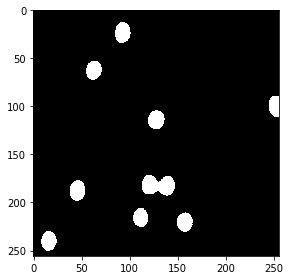

In [39]:
#Process and image
def process_img(img_file, shape = (256,256)):
    img = imread(img_file, plugin='tifffile', as_gray = True)
    img = transform.resize(img, shape)
    #img = img/255
    return(img)
test_image_file = HOMEDIR + BBBCMASK_DIR + '/test/image/class0/SIMCEPImages_A18_C74_F1_s08_w1.TIF'
test_image_file = '/home/andy-pohl/Documents/ssc_challenge/ssc-case-study-2019/ssc-data/train/A03_C10_F1_s01_w1.TIF'
test_img = process_img(test_image_file)
imshow(test_img)
pred = unet.predict(test_img.reshape(1,256,256,1))
imshow(pred.round(0).reshape((256,256)))

In [21]:
imshow(test_img)

'2019-05-17_10:57:27'